In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI



In [2]:
load_dotenv(override=True)

True

In [3]:
class State(TypedDict):
    
    # A dictionary with the key 'messages' and with these annotations
    # This annotation tells LangGraph the type, and how to update it - the "reducer"
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State) -> State:
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [5]:
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

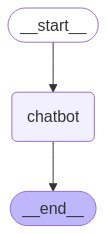

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def invoke_graph(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7892

To create a public link, set `share=True` in `launch()`.


In [ ]:

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... The capital and by far the most important city of France is Paris, one of the world's preeminent cultural and commercial centres. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... NARRATOR: The Eiffel Towe

In [44]:
tool =Tool(
        name="Intermediate_answer",
        func=serper.run,
        description="useful for when you need to ask with search"
    )

tool.invoke("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... The capital and by far the most important city of France is Paris, one of the world's preeminent cultural and commercial centres. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most ... NARRATOR: The Eiffel Tower is the best-known symbol of Paris, the capital of France. Paris is an important center for business and culture. With its wide ... Paris is the city of romance 

In [57]:
def push(text: str):
    """Send a push notification to the user"""
    requests.post(
        "https://api.pushover.net/1/messages.json",
        data={
            "token": os.getenv("PUSHOVER_TOKEN"),
            "user": os.getenv("PUSHOVER_USER"),
            "message": text,
        }
    )

tool2 = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool2.invoke("Hello, me")

tools=[tool,tool2]

In [58]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

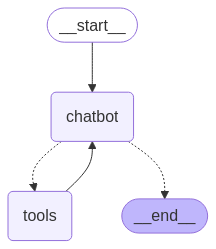

In [59]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
def invoke_graph(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(invoke_graph, type="messages").launch()
 

* Running on local URL:  http://127.0.0.1:7897

To create a public link, set `share=True` in `launch()`.


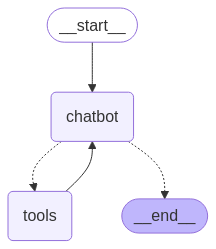

In [52]:
from langgraph.checkpoint.memory import MemorySaver

# Can be a SqlliteSaver or PostgresSaver
memory = MemorySaver()

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [53]:
config = {"configurable": {"thread_id": "1"}}

def invoke_graph(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7896

To create a public link, set `share=True` in `launch()`.
